In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
import json

In [2]:
adapters = {'name': 'adapters_anomaly_injected', 'df': pd.read_csv('data/adapters_anomaly_injected.csv')}
brockers = {'name': 'brokers_anomaly_injected', 'df': pd.read_csv('data/brokers_anomaly_injected.csv')}
callbrocker = {'name': 'callbrocker', 'df': pd.read_csv('data/callbroker.csv')}
chatbrocker = {'name': 'chatbrocker', 'df': pd.read_csv('data/chatbroker.csv')}
combined_logs = {'name': 'combined_logs', 'df': pd.read_csv('data/combined_logs.csv')}
error_samples = {'name': 'error_samples', 'df': pd.read_csv('data/error_samples.csv')}
restamqpgw = {'name': 'restamqpgw_anomaly_injected', 'df': pd.read_csv('data/restamqpgw_anomaly_injected.csv')}
smsbrocker = {'name': 'smsbrocker', 'df': pd.read_csv('data/smsbroker.csv')}

In [3]:
# logs are sorted by length decrease
logs_format1 = [brockers, adapters, restamqpgw]
logs_format2 = [combined_logs, callbrocker, error_samples, chatbrocker, smsbrocker]
assert len(logs_format1) + len(logs_format2) == 8
assert all([len(df1['df']) >= len(df2['df']) for df1, df2 in zip(logs_format1[:-1], logs_format1[1:])])
assert all([len(df1['df']) >= len(df2['df']) for df1, df2 in zip(logs_format2[:-1], logs_format2[1:])])

In [4]:
heads_json = [
    ' Message is: {',
    ' Message to deliver: {',
]
# Logs, which starts from this message contain corrupted JSON, so it is not very clear how to parse it
heads_ignore = [
    ' Message successfully persisted: {',
]

format1_cols = logs_format1[0]['df'].columns.tolist()

for log_dict in logs_format2:
    name = log_dict['name']

    msg_list = []
    for msg in log_dict['df']['Message'].tolist():
        ignore_flag = False
        for head in heads_ignore:
            if msg.startswith(head):
                ignore_flag = True
                break
        if ignore_flag:
            continue
        found_flag = False
        for head in heads_json:
            if msg.startswith(head):
                msg = msg[len(head) - 1:].strip()
                found_flag = True
                break
        if not found_flag:
#             print(f"not parsed: {msg}")
            continue
        try:
            msg_list.append(json.loads(msg))
        except ValueError as e:
            print(f"Not valid msg: {msg}")
            break
    converted_df = pd.json_normalize(msg_list)
    del msg_list
    print(f"{name}: collected {len(converted_df)} rows, {len(converted_df.columns)} columns")

    # restore initial columns
    converted_df.drop(columns=converted_df.columns.difference(format1_cols), inplace=True)
#     converted_df['anomaly'] - no information
    converted_df['correlation_id_length'] = converted_df['messageParams.correlationID'].str.len()
    converted_df['message_id_length'] = converted_df['messageParams.messageID'].str.len()
    converted_df['transaction_id_length'] = converted_df['messageParams.transactionID'].str.len()
#     converted_df['version'] - no information

    if len(converted_df) != len(converted_df.drop_duplicates()):
        print(f"\tFYI: {name} contain duplicates")

    print(f"\tThe following {len(converted_df.columns)} columns filled: {converted_df.columns.tolist()}\n")
    logs_format1.append({'name': log_dict['name'], 'df': converted_df})

combined_logs: collected 928 rows, 58 columns
	The following 15 columns filled: ['version', 'messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'correlation_id_length', 'message_id_length', 'transaction_id_length']

callbrocker: collected 630 rows, 49 columns
	The following 15 columns filled: ['version', 'messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'correlation_id_length', 'message_id_length', 'transaction_id_length']

error_samples: collected 68 rows, 52 columns
	The following 

In [5]:
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * ( r - 1)) / (n - 1))    
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))

for log_dict in logs_format1:
    print(f"{log_dict['name']}\n")
    corr_list = []

    cols = log_dict['df'].columns.to_list()
    if 'version' in cols:
        cols.remove('version')
    cols.remove('messageParams.messageID')
    cols.remove('messageParams.transactionID')

    for i in range(len(cols)):
        if cols[i] == 'messageParams.terminatingMS':
            continue
        conf_matrix = pd.crosstab(log_dict['df'][cols[i]], log_dict['df']['messageParams.terminatingMS']).to_numpy()
        corr = cramers_corrected_stat(conf_matrix)
        print(f"{cols[i]} <-> {'messageParams.terminatingMS'}: {corr}")
        corr_list.append((f"{cols[i]} <-> {'messageParams.terminatingMS'}", corr))
    print()
    corr_list.sort(key=lambda x: x[1])
    print("Best correlations with anomaly:")
    for (label, corr) in corr_list:
        if corr > 0.2:
            print(f"\t{label}: {corr}")
    print()

brokers_anomaly_injected

messageRealm <-> messageParams.terminatingMS: 0.49583597321742295
serviceAction <-> messageParams.terminatingMS: 0.6537404292507586
messageParams.subscriber <-> messageParams.terminatingMS: 0.3853821755328021
messageParams.calledMessageQueue <-> messageParams.terminatingMS: 0.6166915591360171
messageParams.type <-> messageParams.terminatingMS: 0.5136938145950138
messageParams.correlationID <-> messageParams.terminatingMS: 0.18334012364787655
messageParams.originatingMS <-> messageParams.terminatingMS: 0.6150470680535657
serviceData.httpParams.statusCode <-> messageParams.terminatingMS: 0.2665061794736202
message_id_length <-> messageParams.terminatingMS: 0.1259987099809139
correlation_id_length <-> messageParams.terminatingMS: 0.12297574058188106
transaction_id_length <-> messageParams.terminatingMS: 0.1270931284185879
anomaly <-> messageParams.terminatingMS: 0.024595007183691085

Best correlations with anomaly:
	serviceData.httpParams.statusCode <-> messagePa

/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: inva

serviceAction <-> messageParams.terminatingMS: 0.644661285793302
messageParams.subscriber <-> messageParams.terminatingMS: 0.2157277486520025
messageParams.calledMessageQueue <-> messageParams.terminatingMS: 0.6850042111044057
messageParams.type <-> messageParams.terminatingMS: 0.6446612857933021
messageParams.correlationID <-> messageParams.terminatingMS: 0.0
messageParams.originatingMS <-> messageParams.terminatingMS: 0.6961432213383856
serviceData.httpParams.statusCode <-> messageParams.terminatingMS: nan
correlation_id_length <-> messageParams.terminatingMS: nan
message_id_length <-> messageParams.terminatingMS: nan
transaction_id_length <-> messageParams.terminatingMS: 0.442274013953797

Best correlations with anomaly:
	messageParams.subscriber <-> messageParams.terminatingMS: 0.2157277486520025
	transaction_id_length <-> messageParams.terminatingMS: 0.442274013953797
	messageRealm <-> messageParams.terminatingMS: 0.644661285793302
	serviceAction <-> messageParams.terminatingMS: 0

/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_1265/3689695655.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))


In [14]:
for log_dict in logs_format1:
    cols = [
        'messageParams.subscriber',
        'messageRealm',
        'serviceAction',
#         'messageParams.calledMessageQueue',
        'transaction_id_length',
        'serviceData.httpParams.statusCode',
        'messageParams.originatingMS',
    ]
    X = pd.concat([pd.get_dummies(log_dict['df'][col], dtype=int) for col in cols], axis='columns').to_numpy()
    Y = pd.get_dummies(log_dict['df']['messageParams.terminatingMS'], dtype=int).to_numpy()
    print(f"{log_dict['name']}:\n{X.shape = }\n{Y.shape = }\n")
    log_dict['X'] = X
    log_dict['Y'] = Y

brokers_anomaly_injected:
X.shape = (42129, 151)
Y.shape = (42129, 17)

adapters_anomaly_injected:
X.shape = (24164, 499)
Y.shape = (24164, 15)

restamqpgw_anomaly_injected:
X.shape = (11271, 109)
Y.shape = (11271, 10)

combined_logs:
X.shape = (928, 25)
Y.shape = (928, 8)

callbrocker:
X.shape = (630, 18)
Y.shape = (630, 4)

error_samples:
X.shape = (68, 14)
Y.shape = (68, 3)

chatbrocker:
X.shape = (168, 16)
Y.shape = (168, 4)

smsbrocker:
X.shape = (130, 17)
Y.shape = (130, 4)



brokers_anomaly_injected
	Minimal random forest: 0.6915054304826297
	Decision tree: 0.9305905200316479


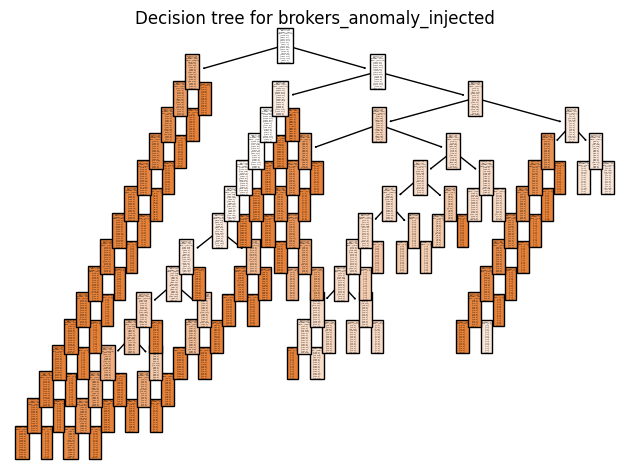

adapters_anomaly_injected
	Minimal random forest: 0.6693416927899687
	Decision tree: 0.9144827586206896


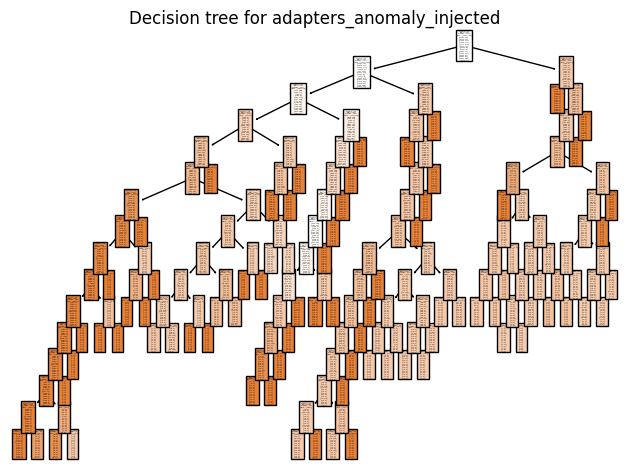

restamqpgw_anomaly_injected
	Minimal random forest: 0.9669354838709677
	Decision tree: 1.0


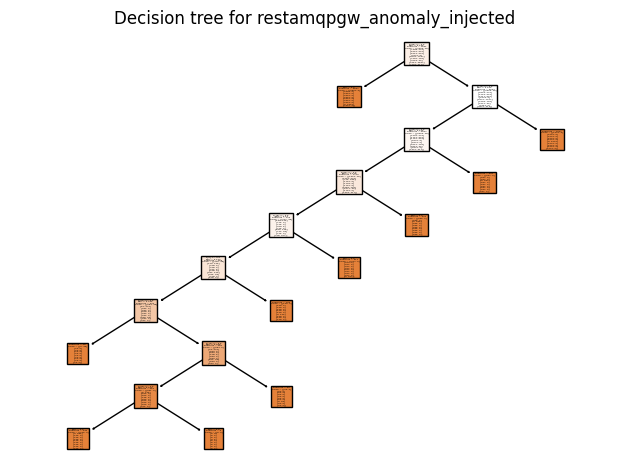

combined_logs
	Minimal random forest: 0.9609120521172638
	Decision tree: 0.9609120521172638


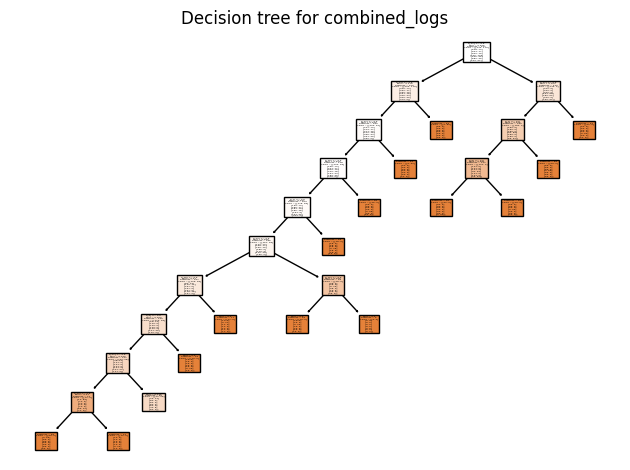

callbrocker
	Minimal random forest: 1.0
	Decision tree: 1.0


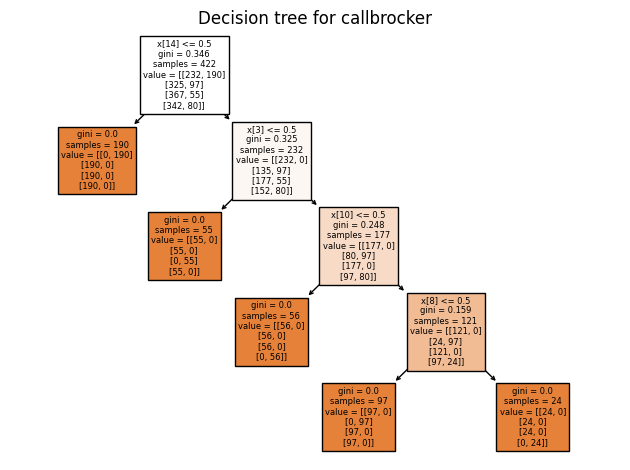

error_samples
	Minimal random forest: 1.0
	Decision tree: 1.0


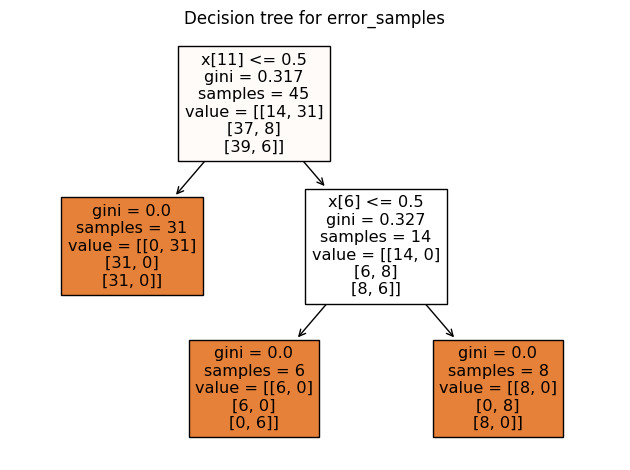

chatbrocker
	Minimal random forest: 1.0
	Decision tree: 1.0


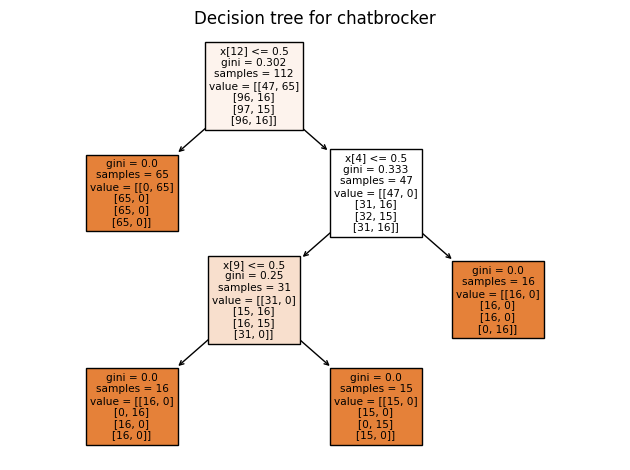

smsbrocker
	Minimal random forest: 1.0
	Decision tree: 1.0


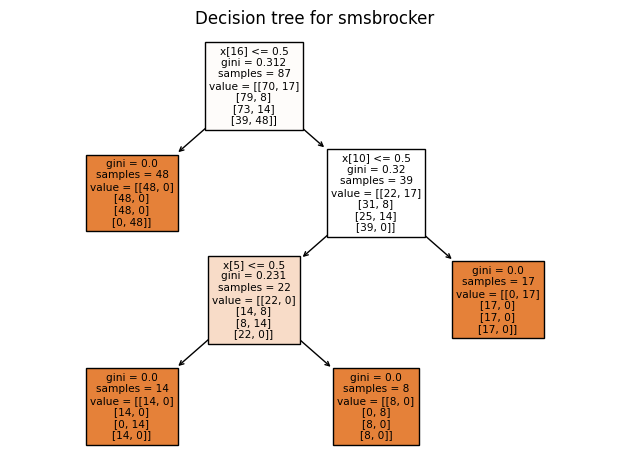

In [16]:
for log_dict in logs_format1:
    print(log_dict['name'])
    X_train, X_test, Y_train, Y_test = train_test_split(
        log_dict['X'], log_dict['Y'], test_size=0.33, random_state=0,
    )
    clf = RandomForestClassifier(n_estimators=2, max_depth=10, random_state=0)
    clf.fit(X_train, Y_train)
    print(f"\tMinimal random forest: {clf.score(X_test, Y_test)}")
    clf = DecisionTreeClassifier(random_state=0, max_depth=15)
    clf.fit(X_train, Y_train)
    print(f"\tDecision tree: {clf.score(X_test, Y_test)}")

    plt.figure()
    plot_tree(clf, filled=True)
    plt.title(f"Decision tree for {log_dict['name']}")
    plt.tight_layout()
    plt.show()

In [ ]:
# for log_dict in logs_format1:
#     print(log_dict['name'])
# #     df_train, df_test = train_test_split(
# #         log_dict['df'], test_size=0.33, random_state=0,
# #     )
#     df_test = log_dict['df']
#     pred_y = []
#     for row in df_test.itertuples(index=False):
#         val = 1 if (
#             row.message_id_length == 16 or
#             row.correlation_id_length == 24 or
#             row.transaction_id_length == 30 or
#             # row._10 is "serviceData.httpParams.statusCode"
#             row._10 not in [0, 200, 201, 202, 204, 303]
#             ) else 0
#         pred_y.append(val)
#     pred_y = np.array(pred_y).T
#     y_test = df_test['anomaly'].apply(lambda x: 0 if x == 'no' else 1).to_numpy().T
#     print(f"\tAccuracy for analytical rule: {accuracy_score(y_test, pred_y)}")